# DiffiT: Diffusion Vision Transformers for Image Generation

DiffiT introduces a novel approach to generative learning by combining Vision Transformers (ViTs) with diffusion-based models. Leveraging the Time-dependent Multihead Self Attention (TMSA) mechanism, DiffiT achieves impressive results in high-fidelity image generation. It outperforms other Transformer-based diffusion models while maintaining parameter efficiency. Further exploration of DiffiT's methodology promises exciting advancements in generative AI. They proposed latent and image space DiffiT models

## What is a diffusion model? [3]

A (denoising) diffusion model isn't that complex if you compare it to other generative models such as Normalizing Flows, GANs or VAEs: they all convert noise from some simple distribution to a data sample. This is also the case here where a neural network learns to gradually denoise data starting from pure noise.

In a bit more detail for images, the set-up consists of 2 processes:

* a fixed (or predefined) forward diffusion process $q$ of our choosing, that gradually adds Gaussian noise to an image, until you end up with pure noise
* a learned reverse denoising diffusion process $p_\theta$, where a neural network is trained to gradually denoise an image starting from pure noise, until you end up with an actual image.

<img src="https://raw.githubusercontent.com/alighasemi78/DiffiT-Diffusion-Vision-Transformers-for-Image-Generation/a54262db80e6c49c1a39a1b4596aa981763a31b2/images/diff_model.png" alt="diffusion architecture" height="200"/>

Both the forward and reverse process indexed by $t$ happen for some number of finite time steps $T$ (the DDPM authors use $T = 1000$). You start with $t = 0$ where you sample a real image $x_0$ from your data distribution, and the forward process samples some noise from a Gaussian distribution at each time step $t$, which is added to the image of the previous time step. Given a sufficiently large $T$ and a well behaved schedule for adding noise at each time step, you end up with what is called an isotropic Gaussian distribution at $t = T$ via a gradual process.

Let $q(x_0)$ be the real data distribution, say of "real images". We can sample from this distribution to get an image, $x_0 \sim q(x_0)$. We define the forward diffusion process $q(x_t | x_{t - 1})$ which adds Gaussian noise at each time step $t$, according to a known variance schedule $0 < \beta_1 < \beta_2 < \cdots < \beta_T < 1$ as

$$q(x_t | x_{t - 1}) = N(x_t; \sqrt{1 - \beta_t}x_{t - 1}, \beta_tI)$$

Recall that a normal distribution (also called Gaussian distribution) is defined by 2 parameters: a mean $\mu$ and a variance $\sigma^2 \ge 0$. Basically, each new (slightly noisier) image at time step $t$ is drawn from a conditional Gaussian distribution with $\mu_t = \sqrt(1 - \beta_t)x_{t - 1}$
and $\sigma_t^2 = \beta_t$, which we can do by sampling $\epsilon \sim N(0,I)$ and then setting $x_t = \sqrt{1 - β_t}x_{t - 1} + \beta_t\epsilon$.

Note that the $\beta_t$ aren't constant at each time step $t$ (hence the subscript) --- in fact one defines a so-called "variance schedule", which can be linear, quadratic, cosine, etc.

So starting from $x_0$, we end up with $x_1, \cdots, x_t, \cdots, x_T$, where $x_T$ is pure Gaussian noise if we set the schedule appropriately.

Now, if we knew the conditional distribution $p(x_{t - 1} | x_t)$, then we could run the process in reverse: by sampling some random Gaussian noise $x_T$, and then gradually "denoise" it so that we end up with a sample from the real distribution $x_0$.

However, we don't know $p(x_{t - 1} | x_t)$. It's intractable since it requires knowing the distribution of all possible images in order to calculate this conditional probability. Hence, we're going to leverage a neural network to approximate (learn) this conditional probability distribution, let's call it $p_\theta(x_{t - 1} | x_t)$, with $\theta$ being the parameters of the neural network, updated by gradient descent.

Ok, so we need a neural network to represent a (conditional) probability distribution of the backward process. If we assume this reverse process is Gaussian as well, then recall that any Gaussian distribution is defined by 2 parameters:

* a mean parametrized by $\mu_\theta$;
* a variance parametrized by $\Sigma_\theta$;

so we can parametrize the process as

$$p_\theta(x_{t - 1} | x_t) = N(x_{t - 1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$

where the mean and variance are also conditioned on the noise level $t$.

Hence, our neural network needs to learn/represent the mean and variance. However, the DDPM authors decided to keep the variance fixed, and let the neural network only learn (represent) the mean $\mu_\theta$ of this conditional probability distribution.

To derive an objective function to learn the mean of the backward process, the authors observe that the combination of $q$ and $p_\theta$ can be seen as a variational auto-encoder (VAE). Hence, the variational lower bound (also called ELBO) can be used to minimize the negative log-likelihood with respect to ground truth data sample $x_0$. It turns out that the ELBO for this process is a sum of losses at each time step $t$, $L = L_0 + L_1 + \cdots + L_T$. By construction of the forward $q$ process and backward process, each term (except for $L_0$) of the loss is actually the KL divergence between 2 Gaussian distributions which can be written explicitly as an L2-loss with respect to the means!

A direct consequence of the constructed forward process $q$ is that we can sample $x_t$ at any arbitrary noise level conditioned on $x_0$ (since sums of Gaussians is also Gaussian). This is very convenient: we don't need to apply $q$ repeatedly in order to sample $x_t$. We have that

$$q(x_t | x_0) = N(x_t; \sqrt{\bar{\alpha_t}}x_0; (1 - \bar{\alpha_t})I)$$

with $\alpha_t := 1 - \beta_t$ and $\bar{a}_t := \prod_{s = 1}^t \alpha_s$. Let's refer to this equation as the "nice property". This means we can sample Gaussian noise and scale it appropriatly and add it to $x_0$ to get $x_t$ directly. Note that the $\bar{\alpha_t}$ are functions of the known $\beta_t$ variance schedule and thus are also known and can be precomputed. This then allows us, during training, to optimize random terms of the loss function $L$ (or in other words, to randomly sample $t$ during training and optimize $L_t$).

Another beauty of this property is that one can instead reparametrize the mean to make the neural network learn (predict) the added noise (via a network $\epsilon_\theta(x_t, t)$) for noise level $t$ in the KL terms which constitute the losses. This means that our neural network becomes a noise predictor, rather than a (direct) mean predictor. The mean can be computed as follows:

$$\mu_\theta(x_t, t) = \dfrac{1}{\sqrt{\alpha_t}}(x_t - \dfrac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}}\epsilon_\theta(x_t, t))$$

The final objective function $L_t$ then looks as follows (for a random time step $t$ given $\epsilon \sim N(0, I)$):

$$||\epsilon - \epsilon_\theta(x_t, t)||^2 = ||\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha_t}}x_0 + \sqrt{(1 - \bar{\alpha_t})}\epsilon, t)||^2$$

Here, $x_0$ is the initial (real, uncorrupted) image, and we see the direct noise level $t$ sample given by the fixed forward process. $\epsilon$ is the pure noise sampled at time step $t$, and $\epsilon_\theta(x_t,t)$ is our neural network. The neural network is optimized using a simple mean squared error (MSE) between the true and the predicted Gaussian noise.

The training algorithm now looks as follows:

<img src="https://raw.githubusercontent.com/alighasemi78/DiffiT-Diffusion-Vision-Transformers-for-Image-Generation/07d705c2e34c34fcbf13f5a9dcc1c9263d055f28/images/diff_train.png" alt="diffusion training" height="200" />

In other words:

* we take a random sample $x_0$ from the real unknown and possibily complex data distribution $q(x_0)$
* we sample a noise level $t$ uniformally between $1$ and $T$ (i.e., a random time step)
* we sample some noise from a Gaussian distribution and corrupt the input by this noise at level $t$ (using the nice property defined above)
* the neural network is trained to predict this noise based on the corrupted image $x_t$ (i.e. noise applied on $x_0$ based on known schedule $\beta_t$)

In reality, all of this is done on batches of data, as one uses stochastic gradient descent to optimize neural networks.

## Installing the Required Libraries

In [ ]:
%%capture
!pip install -q datasets pytorch_lightning torchmetrics[image]

## Importing the Required Libraries

In [ ]:
from google.colab import drive
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
from torch import nn
import math
import pytorch_lightning as pl
import torch.nn.functional as F
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar
from tqdm import tqdm
import random
from torchmetrics.image.fid import FrechetInceptionDistance

## Settings

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Hyperparameters

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 32

N_EPOCH = 3

D_MODEL = 128
N_HEAD = 2
DROPOUT_PROB = 0.1
D_FF = 2 * D_MODEL

T = 500

## Dataset

In [ ]:
def get_data(name):
    # Determine the dataset checkpoint based on the provided name.
    # If the name is 'cifar', use the 'cifar10' dataset.
    # Otherwise, use the 'zh-plus/tiny-imagenet' dataset.
    checkpoint = 'cifar10' if name == 'cifar' else 'zh-plus/tiny-imagenet'

    # Download the dataset using the determined checkpoint.
    dataset = load_dataset(checkpoint)

    # Extract the training set.
    train = dataset['train']

    # Extract the test set for 'cifar' or validation set for 'tiny-imagenet'.
    test = dataset['test'] if name == 'cifar' else dataset['valid']

    # Set the transformation for the images.
    # If the dataset is 'cifar', simply convert images to tensor.
    # Otherwise, resize the images to 32x32 and then convert to tensor.
    if name == 'cifar':
        transform = transforms.ToTensor()
    else:
        transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
        ])

    # Initialize lists to hold transformed training images.
    train_transformed = []

    # Loop through each image in the training set, apply the transformation,
    # and add the transformed image to the list.
    for image in train:
        # Depending on the dataset, select the appropriate key to get the image.
        img = transform(image['img'] if name == 'cifar' else image['image'])

        # Append the transformed image to the list if it has 3 channels (RGB).
        if name == 'cifar' or img.shape[0] == 3:
            train_transformed.append(img)

    # Initialize lists to hold transformed test/validation images.
    test_transformed = []

    # Loop through each image in the test/validation set, apply the transformation,
    # and add the transformed image to the list.
    for image in test:
        # Depending on the dataset, select the appropriate key to get the image.
        img = transform(image['img'] if name == 'cifar' else image['image'])

        # Append the transformed image to the list if it has 3 channels (RGB).
        if name == 'cifar' or img.shape[0] == 3:
            test_transformed.append(img)

    # Create a DataLoader for the training set with the specified batch size,
    # shuffling enabled, and using 2 worker threads for loading data.
    train_loader = DataLoader(train_transformed, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    # Create a DataLoader for the test/validation set with the specified batch size,
    # shuffling disabled, and using 2 worker threads for loading data.
    test_loader = DataLoader(test_transformed, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # Return the DataLoaders for the training and test/validation sets.
    return train_loader, test_loader, train_transformed, test_transformed

In [ ]:
# Retrieve the DataLoaders for the CIFAR dataset.
# The get_data function is called with the argument 'cifar',
# which will download and process the CIFAR-10 dataset.
cifar_train_loader, cifar_test_loader, cifar_train_ds, cifar_test_ds = get_data('cifar')

# Retrieve the DataLoaders for the Tiny ImageNet dataset.
# The get_data function is called with the argument 'tiny_imagenet',
# which will download and process the Tiny ImageNet dataset.
imagenet_train_loader, imagenet_test_loader, imagenet_train_ds, imagenet_test_ds = get_data('tiny_imagenet')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Rendering an example data sample

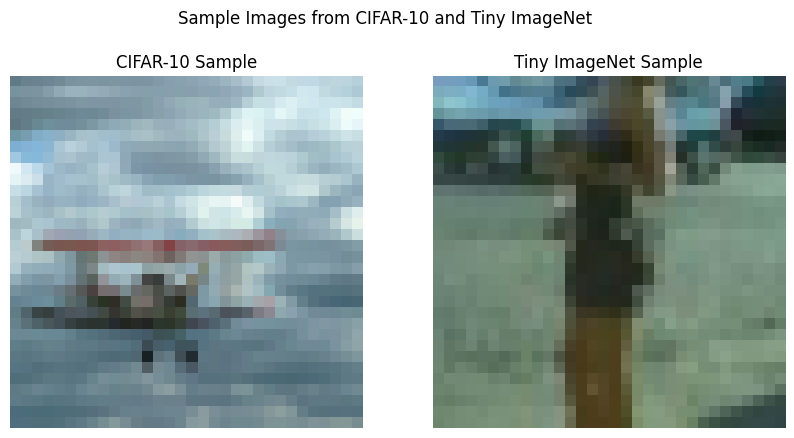

In [ ]:
# Get one batch of CIFAR data
cifar_images = next(iter(cifar_train_loader))
# Get one batch of Tiny ImageNet data
imagenet_images = next(iter(imagenet_train_loader))

# Get the first image from each batch
cifar_image = cifar_images[0]
imagenet_image = imagenet_images[0]

# Set up the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot CIFAR image
npimg_cifar = cifar_image.permute(1, 2, 0).numpy()
axs[0].imshow(npimg_cifar)
axs[0].set_title('CIFAR-10 Sample')
axs[0].axis('off')

# Plot Tiny ImageNet image
npimg_imagenet = imagenet_image.permute(1, 2, 0).numpy()
axs[1].imshow(npimg_imagenet)
axs[1].set_title('Tiny ImageNet Sample')
axs[1].axis('off')

# Set a super title for the figure
fig.suptitle('Sample Images from CIFAR-10 and Tiny ImageNet')

# Show the plot
plt.show()

## Noisification [3]

The forward diffusion process gradually adds noise to an image from the real distribution, in a number of time steps T. This happens according to a variance schedule. The original DDPM (Denoising Diffusion Probabilistic Models) authors employed a linear schedule:



> We set the forward process variances to constants increasing linearly from $\beta_1 = 10^{-4}$ to $\beta_T = 0.02$

In [ ]:
def linear_beta_schedule(timesteps):
    """
    Generate a linearly spaced sequence of beta values for a given number of timesteps.

    Parameters:
    timesteps (int): The number of timesteps for which to generate the beta values.

    Returns:
    torch.Tensor: A tensor containing the linearly spaced beta values.
    """

    # Define the starting value of beta.
    beta_start = 0.0001

    # Define the ending value of beta.
    beta_end = 0.02

    # Generate a linearly spaced sequence of values from beta_start to beta_end over the given number of timesteps.
    beta_values = torch.linspace(beta_start, beta_end, timesteps)

    return beta_values

The extract function will allow us to extract the appropriate $t$ index for a batch of indices.

In [ ]:
def extract(a, t, batch_shape):
    """
    Extracts elements from tensor `a` at indices specified by tensor `t`, and reshapes the output
    to be compatible with the given `batch_shape`.

    Parameters:
    a (torch.Tensor): A tensor from which to extract elements.
    t (torch.Tensor): A tensor of indices specifying which elements to extract from `a`.
    batch_shape (tuple): The desired shape of the output, excluding the first dimension which corresponds to `num_timesteps`.

    Returns:
    torch.Tensor: A tensor of extracted elements reshaped to be compatible with `batch_shape`.
    """

    # Get the number of timesteps, which is the length of the indices tensor `t`.
    num_timesteps = t.shape[0]

    # Use the gather method to extract elements from `a` at indices specified by `t`.
    # Since gather operates on the last dimension, `t` is moved to the CPU.
    out = a.gather(-1, t.cpu())

    # Reshape the extracted elements to be compatible with `batch_shape`.
    # The first dimension will be `num_timesteps`, and the remaining dimensions will be ones.
    # This ensures the output tensor can be broadcasted to match `batch_shape`.
    reshaped_out = out.reshape(num_timesteps, *((1,) * (len(batch_shape) - 1)))

    # Move the reshaped tensor to the device of `t` and return it.
    return reshaped_out.to(t.device)

In [ ]:
def q_sample(batch, timesteps, t, noise):
    """
    Samples from the diffusion process q(x_t | x_{t-1}) for a given batch of data.

    Parameters:
    batch (torch.Tensor): The batch of data to be diffused.
    timesteps (int): The total number of timesteps in the diffusion process.
    t (torch.Tensor): A tensor of current timestep indices for each element in the batch.
    noise (torch.Tensor): A tensor of noise to be added to the batch.

    Returns:
    torch.Tensor: The diffused batch of data.
    """

    # Define the beta schedule for the given number of timesteps.
    betas = linear_beta_schedule(timesteps)

    # Compute alphas as (1 - betas).
    alphas = 1. - betas

    # Compute the cumulative product of alphas to get alpha_bar values.
    alphas_bar = torch.cumprod(alphas, axis=0)

    # Compute square roots of alpha_bar and (1 - alpha_bar) for use in the sampling equation.
    sqrt_alphas_bar = torch.sqrt(alphas_bar)
    sqrt_one_minus_alphas_bar = torch.sqrt(1. - alphas_bar)

    # Extract the corresponding alpha_bar and (1 - alpha_bar) values for the current timesteps.
    sqrt_alphas_bar_t = extract(sqrt_alphas_bar, t, batch.shape)
    sqrt_one_minus_alphas_bar_t = extract(sqrt_one_minus_alphas_bar, t, batch.shape)

    # Compute the diffused data by combining the original batch and the noise,
    # weighted by the square roots of the corresponding alpha_bar and (1 - alpha_bar) values.
    diffused_data = sqrt_alphas_bar_t * batch + sqrt_one_minus_alphas_bar_t * noise

    return diffused_data

In [ ]:
def noisify(batch, timesteps, t):
    """
    Adds Gaussian noise to a batch of data according to the diffusion process q(x_t | x_{t-1}).

    Parameters:
    batch (torch.Tensor): The batch of data to which noise will be added.
    timesteps (int): The total number of timesteps in the diffusion process.
    t (torch.Tensor): A tensor of current timestep indices for each element in the batch.

    Returns:
    tuple: A tuple containing the noisy batch of data and the noise tensor.
    """

    # Generate Gaussian noise with the same shape as the batch.
    noise = torch.randn_like(batch)

    # Apply the noise to the batch using the q_sample function to get the noisy batch.
    batch_noisy = q_sample(batch, timesteps, t, noise)

    # Return the noisy batch and the noise used to generate it.
    return batch_noisy, noise

### Noisifying an example data sample

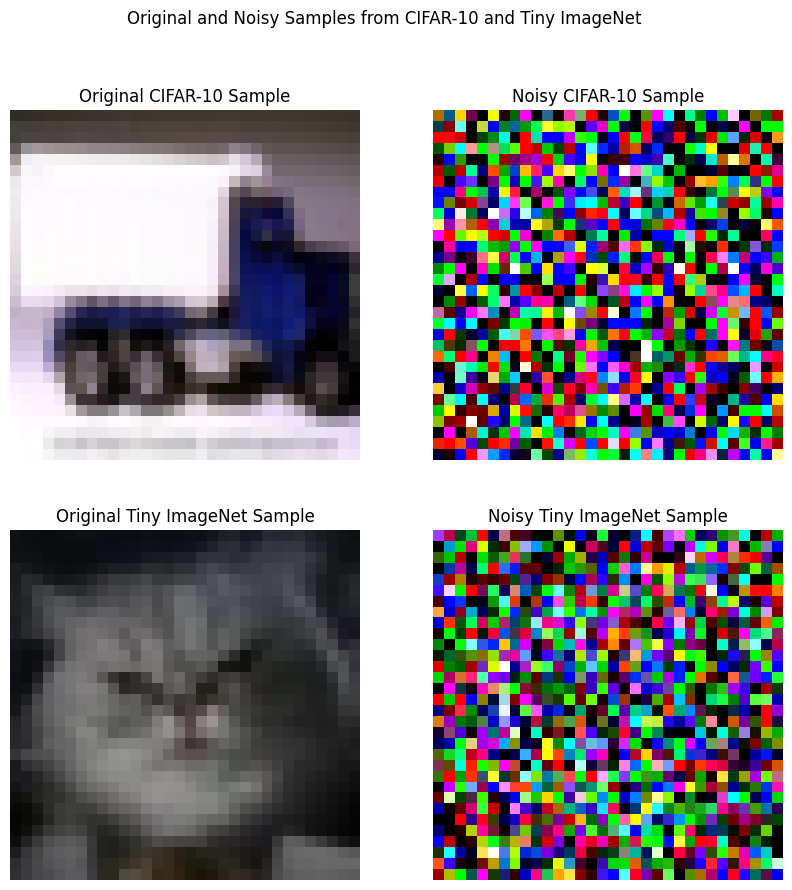

In [ ]:
# Get one batch of CIFAR data
cifar_images = next(iter(cifar_train_loader))
# Get one batch of Tiny ImageNet data
imagenet_images = next(iter(imagenet_train_loader))

# Get the first image from each batch
cifar_image = cifar_images[0]
imagenet_image = imagenet_images[0]

# Generate random timesteps
t_cifar = torch.randint(0, T, (1,))
t_imagenet = torch.randint(0, T, (1,))

# Noisify the images
noisy_cifar, _ = noisify(cifar_image.unsqueeze(0), T, t_cifar)
noisy_imagenet, _ = noisify(imagenet_image.unsqueeze(0), T, t_imagenet)

# Set up the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot original CIFAR image
cifar_image = cifar_image.permute(1, 2, 0).numpy()
axs[0, 0].imshow(cifar_image)
axs[0, 0].set_title('Original CIFAR-10 Sample')
axs[0, 0].axis('off')

# Plot noisy CIFAR image
noisy_cifar_image = noisy_cifar.squeeze(0)
noisy_cifar_image = noisy_cifar_image.permute(1, 2, 0).numpy()
axs[0, 1].imshow(noisy_cifar_image)
axs[0, 1].set_title('Noisy CIFAR-10 Sample')
axs[0, 1].axis('off')

# Plot original Tiny ImageNet image
imagenet_image = imagenet_image.permute(1, 2, 0).numpy()
axs[1, 0].imshow(imagenet_image)
axs[1, 0].set_title('Original Tiny ImageNet Sample')
axs[1, 0].axis('off')

# Plot noisy Tiny ImageNet image
noisy_imagenet_image = noisy_imagenet.squeeze(0)
noisy_imagenet_image = noisy_imagenet_image.permute(1, 2, 0).numpy()
axs[1, 1].imshow(noisy_imagenet_image)
axs[1, 1].set_title('Noisy Tiny ImageNet Sample')
axs[1, 1].axis('off')

# Set a super title for the figure
fig.suptitle('Original and Noisy Samples from CIFAR-10 and Tiny ImageNet')

# Show the plot
plt.show()

## Image Space DiffiT Model

<img src="https://raw.githubusercontent.com/alighasemi78/DiffiT-Diffusion-Vision-Transformers-for-Image-Generation/677536a2ab2076fa9b7bece6242ad2642dbbbf6e/images/image_space_diffit.png" alt="image space diffit" height="500"/>

As shown in the Figure, DiffiT uses a symmetrical U-Shaped encoder-decoder architecture in which the contracting and expanding paths are connected to each other via skip connections at every resolution. Specifically, each resolution of the encoder or decoder paths consists of L consecutive DiffiT blocks, containing our proposed time-dependent self-attention modules. In the beginning of each path, for both the encoder and decoder, a convolutional layer is employed to match the number of feature maps. A convolutional upsampling or downsampling layer is also used for transitioning between each resolution. We speculate that the use of these convolutional layers embeds inductive image bias that can further improve the performance.

### Tokenizer [1]

In [ ]:
class Tokenizer(nn.Module):
    """
    Tokenizer module for tokenizing input images.
    """

    def __init__(self, out_channels, in_channels=3):
        """
        Initializes the Tokenizer module.

        Parameters:
        - out_channels (int): Number of output channels.
        - in_channels (int): Number of input channels (default is 3 for RGB images).
        """

        super().__init__()

        # Define a 2D convolutional layer for tokenizing input images.
        # The convolutional layer has in_channels input channels, out_channels output channels,
        # and uses a kernel size of 3x3 with padding of 1 to maintain spatial dimensions.
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)

    def forward(self, x):
        """
        Forward pass of the Tokenizer module.

        Parameters:
        - x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width).

        Returns:
        - torch.Tensor: Output tensor after tokenization, with shape (batch_size, out_channels, height, width).
        """

        # Pass the input tensor through the convolutional layer.
        # This applies tokenization to the input images.
        return self.conv(x)

### DiffiT ResBlock

#### Time Embeddings

As the parameters of the neural network are shared across time (noise level), the authors employ sinusoidal position embeddings to encode $t$, inspired by the Transformer. This makes the neural network "know" at which particular time step (noise level) it is operating, for every image in a batch.

The SinusoidalPositionEmbeddings module takes a tensor of shape (batch_size, 1) as input (i.e. the noise levels of several noisy images in a batch), and turns this into a tensor of shape (batch_size, dim), with dim being the dimensionality of the position embeddings. This is then added to each residual block, as we will see further.

The model receives $x_t$, a time token representing the time step. We obtain the time token by feeding positional time embeddings to a small MLP with swish activation

##### Position Embeddings [3]

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
    Sinusoidal Position Embeddings module for adding positional encodings to input sequences.
    """

    def __init__(self, dim):
        """
        Initializes the SinusoidalPositionEmbeddings module.

        Parameters:
        - dim (int): Dimensionality of the positional embeddings.
        """

        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        Forward pass of the SinusoidalPositionEmbeddings module.

        Parameters:
        - time (torch.Tensor): Input tensor representing the positions or timestamps.

        Returns:
        - torch.Tensor: Positional embeddings for the input timestamps.
        """

        # Get the device of the input tensor
        device = time.device

        # Calculate half the dimension
        half_dim = self.dim // 2

        # Calculate the embeddings using the sinusoidal formula
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]

        # Concatenate the sine and cosine embeddings along the last dimension
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings

##### Time Embeddings [1]

In [ ]:
class TimeEmbedding(nn.Module):
    """
    Time Embedding module for embedding timestamps with positional encodings.
    """

    def __init__(self, d_model, seq_len):
        """
        Initializes the TimeEmbedding module.

        Parameters:
        - d_model (int): Dimensionality of the model.
        - seq_len (int): Length of the sequence (number of timestamps).
        """

        super().__init__()

        # Instantiate SinusoidalPositionEmbeddings module for positional encodings
        self.positional_encoding = SinusoidalPositionEmbeddings(seq_len)

        # Linear layer for embedding positional encodings
        self.fc1 = nn.Linear(seq_len, d_model)

        # Activation function (Swish)
        self.swish = nn.SiLU()

        # Second linear layer for further transformation
        self.fc2 = nn.Linear(d_model, d_model)

    def forward(self, t):
        """
        Forward pass of the TimeEmbedding module.

        Parameters:
        - t (torch.Tensor): Input tensor representing timestamps.

        Returns:
        - torch.Tensor: Embedded tensor representing the timestamps with positional encodings.
        """

        # Apply positional encoding to input timestamps
        x_t = self.positional_encoding(t)

        # Linear transformation to embed positional encodings
        x_t = self.fc1(x_t)

        # Apply activation function (Swish)
        x_t = self.swish(x_t)

        # Further linear transformation
        x_t = self.fc2(x_t)

        return x_t

#### DiffiT Transformer

<img src="https://raw.githubusercontent.com/alighasemi78/DiffiT-Diffusion-Vision-Transformers-for-Image-Generation/d576c8725b797d45f9a066ac056d75b20581bcf2/images/diffit_transformer.png" alt="diffit transformer" height="500"/>

The transformer block is a core building block of the proposed DiffiT architecture and is defined as

$$\hat{x_s} = \text{TMSA}(\text{LN}(x_s), x_t) + x_s$$
$$x_s = \text{MLP}(\text{LN}(\hat{x_s})) + \hat{x_s}$$

where TMSA denotes time-dependent multi-head self-attention, $x_t$ is the time-embedding token, $x_s$ is a spatial token, and LN and MLP denote Layer Norm and MLP respectively.

##### Layer Norm [4]

In [ ]:
class LayerNorm(nn.Module):
    """
    Layer Normalization module for normalizing input tensors.
    """

    def __init__(self, eps=1e-6):
        """
        Initializes the LayerNorm module.

        Parameters:
        - eps (float): A small constant to prevent division by zero.
        """

        super().__init__()
        self.eps = eps

        # Learnable parameters: alpha (scaling factor) and bias
        self.alpha = nn.Parameter(torch.ones(1))    # Multiplies
        self.bias = nn.Parameter(torch.zeros(1))    # Added

    def forward(self, x):
        """
        Forward pass of the LayerNorm module.

        Parameters:
        - x (torch.Tensor): Input tensor to be normalized.

        Returns:
        - torch.Tensor: Normalized output tensor.
        """

        # Calculate mean and standard deviation along the last dimension
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)

        # Apply layer normalization formula
        normalized_x = self.alpha * (x - mean) / (std + self.eps) + self.bias

        return normalized_x

##### TMSA [1][4]

In this work, they introduce the Time-dependant Multihead Self-Attention (TMSA) mechanism which allows for fine-grained control over spatial and temporal dependencies and their interaction during the denoising process. Specifically, our TMSA proposes to integrate the temporal component into the self-attention where the key, query, and value weights are adapted per time step during denoising. This allows the denoising network to dynamically change its attention mechanism in different stages by considering both spatial and temporal components and their correspondence.

In addition, employing TMSA significantly improves the parameter efficiency as it only learns three temporal components for query, key and value in each block.

Time-dependent multi-head self-attention captures both long-range spatial and temporal dependencies by projecting feature and time token embeddings in a shared space. Specifically, time-dependent queries q, keys k and values v in the shared space are computed by a linear projection of spatial and time embeddings $x_s$ and $x_t$ via

$$q_s = x_sW_{qs} + x_tW_{qt}$$
$$k_s = x_sW_{ks} + x_tW_{kt}$$
$$v_s = x_sW_{vs} + x_tW_{vt}$$

where $W_{qs}, W_{qt}, W_{ks}, W_{kt}, W_{vs}, W_{vt}$ denote spatial and temporal linear projection weights for their corresponding queries, keys, and values respectively.

We note that the operations listed above are equivalent to a linear projection of each spatial token, concatenated with the time token. As a result, key, query, and value are all linear functions of both time and spatial tokens and they can adaptively modify the behavior of attention for different time steps. We define $Q := \{q_s\}, K := \{k_s\}, V := \{v_s\}$ which are stacked form of query, key, and values in rows of a matrix. The self-attention is then computed as follows

$$\text{Attention}(Q, K, V) = \text{Softmax}(\dfrac{QK^T}{\sqrt{d}} + B)V$$

In which, $d$ is a scaling factor for keys K, and B corresponds to a relative position bias.

In [ ]:
def causal_mask(size):
    """
    Creates a causal mask for self-attention mechanism.

    Parameters:
    - size (int): The size of the mask (number of tokens).

    Returns:
    - torch.Tensor: The causal mask tensor.
    """

    # Create a lower triangular matrix filled with ones
    mask = torch.tril(torch.ones((1, size, size)))

    # Convert the matrix to boolean type
    mask = mask.type(torch.bool).to(device)

    return mask

In [ ]:
class TMSA(nn.Module):
    """
    Transformer-based Multi-Head Attention (TMSA) module for integrating spatial and temporal features.
    """

    def __init__(self, d_model, n_head, img_size, dropout=0.1):
        """
        Initializes the TMSA module.

        Parameters:
        - d_model (int): Dimensionality of the model.
        - n_head (int): Number of attention heads.
        - img_size (int): Size of the input images (assuming square images).
        - dropout (float): Dropout probability (default is 0.1).
        """

        super().__init__()
        self.d_model = d_model
        self.n_head = n_head

        # Ensure that d_model is divisible by n_head
        assert d_model % n_head == 0, 'd_model should be divided by n_head'

        self.img_size = img_size
        self.seq_len = self.img_size * self.img_size
        self.d_head = d_model // n_head

        # Create causal mask for self-attention
        self.mask = causal_mask(self.seq_len)

        # Linear transformations for spatial features
        self.w_qs = nn.Linear(d_model, d_model, False)
        self.w_ks = nn.Linear(d_model, d_model, False)
        self.w_vs = nn.Linear(d_model, d_model, False)

        # Linear transformations for temporal features
        self.w_qt = nn.Linear(d_model, d_model, False)
        self.w_kt = nn.Linear(d_model, d_model, False)
        self.w_vt = nn.Linear(d_model, d_model, False)

        # Learnable bias parameter
        self.b = nn.Parameter(torch.zeros(self.seq_len))

        # Output linear transformation
        self.w_o = nn.Linear(d_model, d_model)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, b, mask, dropout):
        """
        Computes scaled dot-product attention.

        Parameters:
        - query (torch.Tensor): Query tensor.
        - key (torch.Tensor): Key tensor.
        - value (torch.Tensor): Value tensor.
        - b (torch.Tensor): Learnable bias parameter.
        - mask (torch.Tensor): Causal mask for attention.
        - dropout (nn.Dropout): Dropout layer.

        Returns:
        - torch.Tensor: Attention-weighted value tensor.
        - torch.Tensor: Attention scores.
        """

        d_head = query.shape[-1]

        # Compute attention scores
        attention_scores = (query @ key.transpose(-2, -1) + b) / math.sqrt(d_head)

        # Apply causal mask
        attention_scores = attention_scores.masked_fill(mask == 0, -1e9)

        # Apply softmax activation and dropout
        attention_scores = torch.softmax(attention_scores, dim=-1)
        attention_scores = dropout(attention_scores)

        # Compute attention-weighted value tensor
        weighted_value = attention_scores @ value, attention_scores

        return weighted_value

    def forward(self, x_s, x_t):
        """
        Forward pass of the TMSA module.

        Parameters:
        - x_s (torch.Tensor): Spatial features tensor.
        - x_t (torch.Tensor): Temporal features tensor.

        Returns:
        - torch.Tensor: Output tensor after integration of spatial and temporal features.
        """

        # Reshape spatial features tensor
        # (batch, d_model, img_size, img_size) --> (batch, seq_len, d_model)
        x_s = x_s.view(x_s.shape[0], -1, x_s.shape[1])

        # Linear transformations for spatial features
        query_s = self.w_qs(x_s)
        key_s = self.w_ks(x_s)
        value_s = self.w_vs(x_s)

        # (batch, seq_len, d_model) --> (batch, seq_len, n_head, d_head) --> (batch, n_head, seq_len, d_head)
        query_s = query_s.view(query_s.shape[0], -1, self.n_head, self.d_head).transpose(1, 2)
        key_s = key_s.view(key_s.shape[0], -1, self.n_head, self.d_head).transpose(1, 2)
        value_s = value_s.view(value_s.shape[0], -1, self.n_head, self.d_head).transpose(1, 2)

        # Linear transformations for temporal features
        query_t = self.w_qt(x_t)
        key_t = self.w_kt(x_t)
        value_t = self.w_vt(x_t)

        # (batch, seq_len, d_model) --> (batch, seq_len, n_head, d_head) --> (batch, n_head, seq_len, d_head)
        query_t = query_t.view(query_t.shape[0], -1, self.n_head, self.d_head).transpose(1, 2)
        key_t = key_t.view(key_t.shape[0], -1, self.n_head, self.d_head).transpose(1, 2)
        value_t = value_t.view(value_t.shape[0], -1, self.n_head, self.d_head).transpose(1, 2)

        # Combine spatial and temporal queries, keys, and values
        query = query_s + query_t
        key = key_s + key_t
        value = value_s + value_t

        # Compute attention and get attention scores
        x, self.attention_scores = TMSA.attention(query, key, value, self.b, self.mask, self.dropout)

        # Combine attention heads and reshape
        # (batch, n_head, seq_len, d_head) --> (batch, seq_len, n_head, d_head) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.d_model)

        # Output linear transformation
        # (batch, seq_len, d_model) --> (batch_size, d_model, img_size, img_size)
        x = self.w_o(x).view(x.shape[0], x.shape[2], self.img_size, self.img_size)

        return x

##### MLP

In [ ]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron (MLP) module for applying feedforward transformation.
    """

    def __init__(self, img_size, d_ff):
        """
        Initializes the MLP module.

        Parameters:
        - img_size (int): Size of the input features.
        - d_ff (int): Dimensionality of the feedforward layer.
        """

        super().__init__()

        # First linear transformation
        self.fc1 = nn.Linear(img_size, d_ff)

        # Activation function (GELU)
        self.gelu = nn.GELU()

        # Second linear transformation
        self.fc2 = nn.Linear(d_ff, img_size)

    def forward(self, x):
        """
        Forward pass of the MLP module.

        Parameters:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor after applying feedforward transformation.
        """

        # First linear transformation
        x = self.fc1(x)

        # Activation function (GELU)
        x = self.gelu(x)

        # Second linear transformation
        x = self.fc2(x)

        return x

##### DiffiT Transformer [1]

In [ ]:
class DiffiTTransformer(nn.Module):
    """
    Diffusion Transformer (DiffiT) module combining spatial and temporal features.
    """

    def __init__(self, d_model, n_head, img_size, dropout, d_ff):
        """
        Initializes the DiffiTTransformer module.

        Parameters:
        - d_model (int): Dimensionality of the model.
        - n_head (int): Number of attention heads.
        - img_size (int): Size of the input images (assuming square images).
        - dropout (float): Dropout probability.
        - d_ff (int): Dimensionality of the feedforward layer.
        """

        super().__init__()

        # Layer normalization for input spatial features
        self.ln = LayerNorm()

        # Transformer-based Multi-Head Attention (TMSA) module
        self.tmsa = TMSA(d_model, n_head, img_size, dropout)

        # Multi-Layer Perceptron (MLP) module for feedforward transformation
        self.mlp = MLP(img_size, d_ff)

    def forward(self, x_s, x_t):
        """
        Forward pass of the DiffiTTransformer module.

        Parameters:
        - x_s (torch.Tensor): Spatial features tensor.
        - x_t (torch.Tensor): Temporal features tensor.

        Returns:
        - torch.Tensor: Output tensor after integrating spatial and temporal features.
        """

        # Layer normalization for spatial features
        x_hat_s = self.ln(x_s)

        # Apply Transformer-based Multi-Head Attention (TMSA) module
        x_hat_s = self.tmsa(x_hat_s, x_t)

        # Residual connection
        x_hat_s = x_hat_s + x_s

        # Layer normalization
        x_s = self.ln(x_hat_s)

        # Apply Multi-Layer Perceptron (MLP) module
        x_s = self.mlp(x_s)

        # Residual connection
        x_s = x_s + x_hat_s

        return x_s

#### DiffiT ResBlock [1]

We implement the final residual cell by combining the DiffiT Transformer block with an additional convolutional layer in the form:

$$\hat{x_s} = \text{Conv}_{3 \times 3}(\text{Swish}(\text{GN}(x_s)))$$
$$x_s = \text{DiffiT-Block}(\hat{x_s}, x_t) + x_s$$

where GN denotes the group normalization operation and DiffiT-Transformer is defined above. Our residual cell for image space diffusion models is a hybrid cell combining both a convolutional layer and our Transformer block.

In [ ]:
class DiffiTResBlock(nn.Module):
    """
    Residual block with DiffiTTransformer for incorporating temporal information.
    """

    def __init__(self, in_channels, out_channels, d_model, n_head, img_size, dropout, d_ff):
        """
        Initializes the DiffiTResBlock module.

        Parameters:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - d_model (int): Dimensionality of the model.
        - n_head (int): Number of attention heads.
        - img_size (int): Size of the input images (assuming square images).
        - dropout (float): Dropout probability.
        - d_ff (int): Dimensionality of the feedforward layer.
        """

        super().__init__()

        # Calculate sequence length
        self.seq_len = img_size * img_size

        # Group normalization for input channels
        self.gn = nn.GroupNorm(in_channels // 4, in_channels)

        # Swish activation function
        self.swish = nn.SiLU()

        # Convolutional layer
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)

        # Time embeddings for temporal information
        self.time_embeddings = TimeEmbedding(out_channels, self.seq_len)

        # DiffiTTransformer for integrating spatial and temporal features
        self.diffit_transformer = DiffiTTransformer(out_channels, n_head, img_size, dropout, d_ff)

    def forward(self, x_s, t):
        """
        Forward pass of the DiffiTResBlock module.

        Parameters:
        - x_s (torch.Tensor): Spatial features tensor.
        - t (torch.Tensor): Time tensor.

        Returns:
        - torch.Tensor: Output tensor after incorporating temporal information.
        """

        # Group normalization
        x_hat_s = self.gn(x_s)

        # Swish activation
        x_hat_s = self.swish(x_hat_s)

        # Convolutional layer
        x_hat_s = self.conv(x_hat_s)

        # Time embeddings
        x_t = self.time_embeddings(t)

        # DiffiTTransformer for integrating spatial and temporal features
        x_s = self.diffit_transformer(x_hat_s, x_t) + x_s

        return x_s

### DiffiT ResBlock Group [1]

Each resolution of the encoder or decoder paths consists of L consecutive DiffiT blocks, containing the time-dependent self-attention modules.

In [ ]:
class DiffiTResBlockGroup(nn.Module):
    """
    Group of DiffiTResBlocks for incorporating temporal information through multiple layers.
    """

    def __init__(self, in_channels, out_channels, d_model, n_head, img_size, dropout, d_ff, L):
        """
        Initializes the DiffiTResBlockGroup module.

        Parameters:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - d_model (int): Dimensionality of the model.
        - n_head (int): Number of attention heads.
        - img_size (int): Size of the input images (assuming square images).
        - dropout (float): Dropout probability.
        - d_ff (int): Dimensionality of the feedforward layer.
        - L (int): Number of DiffiTResBlocks in the group.
        """

        super().__init__()

        # Create a list of DiffiTResBlocks
        self.diffit_res_blocks = nn.ModuleList([
            DiffiTResBlock(in_channels, out_channels, d_model, n_head, img_size, dropout, d_ff) for _ in range(L)
        ])

    def forward(self, x, t):
        """
        Forward pass of the DiffiTResBlockGroup module.

        Parameters:
        - x (torch.Tensor): Input tensor representing spatial features.
        - t (torch.Tensor): Time tensor.

        Returns:
        - torch.Tensor: Output tensor after incorporating temporal information through multiple layers.
        """

        # Iterate through each DiffiTResBlock in the group
        for diffit_res_block in self.diffit_res_blocks:
            # Apply the current DiffiTResBlock to the input tensor
            x = diffit_res_block(x, t)

        return x

### Downsample & Upsample [1]

A convolutional upsampling or downsampling layer is also used for transitioning between each resolution.

Note that for all networks, the resolution is decreased by a factor of 2 in between stages. However, except for when transitioning from the first to second stage, we keep the number of channels constant in the rest of the stages to maintain both the number of parameters and latency in our network.

#### Downsample

In [ ]:
class Downsample(nn.Module):
    """
    Module for downsampling spatial features.
    """

    def __init__(self, in_channels, out_channels):
        """
        Initializes the Downsample module.

        Parameters:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        """

        super().__init__()

        # Convolutional layer for downsampling
        self.conv = nn.Conv2d(in_channels, out_channels, 3, 2, 1)

    def forward(self, x):
        """
        Forward pass of the Downsample module.

        Parameters:
        - x (torch.Tensor): Input tensor representing spatial features.

        Returns:
        - torch.Tensor: Downsampled spatial features tensor.
        """

        # Apply convolutional layer to downsample the input tensor
        # (batch, in_channels, img_size, img_size) --> (batch, out_channels, img_size/2, img_size/2)
        return self.conv(x)

#### Upsample

In [ ]:
class Upsample(nn.Module):
    """
    Module for upsampling spatial features.
    """

    def __init__(self, in_channels, out_channels):
        """
        Initializes the Upsample module.

        Parameters:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        """

        super().__init__()

        # Transposed convolutional layer for upsampling
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, 3, 2, 1, 1)

    def forward(self, x):
        """
        Forward pass of the Upsample module.

        Parameters:
        - x (torch.Tensor): Input tensor representing spatial features.

        Returns:
        - torch.Tensor: Upsampled spatial features tensor.
        """

        # Apply transposed convolutional layer to upsample the input tensor
        # (batch, in_channels, img_size, img_size) --> (batch, out_channels, img_size*2, img_size*2)
        return self.conv(x)

### Head [1]

In [ ]:
class Head(nn.Module):
    """
    Module representing the head of the model for generating final predictions.
    """

    def __init__(self, in_channels, out_channels=3):
        """
        Initializes the Head module.

        Parameters:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels. Default is 3 for RGB images.
        """

        super().__init__()

        # Group normalization for input channels
        self.gn = nn.GroupNorm(in_channels // 4, in_channels)

        # Convolutional layer for generating final predictions
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)

    def forward(self, x):
        """
        Forward pass of the Head module.

        Parameters:
        - x (torch.Tensor): Input tensor representing features.

        Returns:
        - torch.Tensor: Output tensor representing final predictions.
        """

        # Apply group normalization to the input tensor
        x = self.gn(x)

        # Apply convolutional layer to generate final predictions
        x = self.conv(x)

        return x

### Image Space DiffiT Model [1]

In [ ]:
class ImageSpaceDiffiTModel(pl.LightningModule):
    """
    Model for Image-Space Diffusion Models with Transformers.
    """

    def __init__(self, d_model, n_head, img_size, dropout, d_ff, L1=4, L2=4, L3=4):
        """
        Initializes the ImageSpaceDiffiTModel.

        Parameters:
        - d_model (int): Dimensionality of the model.
        - n_head (int): Number of attention heads.
        - img_size (int): Size of the input images (assuming square images).
        - dropout (float): Dropout probability.
        - d_ff (int): Dimensionality of the feedforward layer.
        - L1 (int): Number of DiffiTResBlocks in the first group. Default is 4.
        - L2 (int): Number of DiffiTResBlocks in the second group. Default is 4.
        - L3 (int): Number of DiffiTResBlocks in the third group. Default is 4.
        """

        super().__init__()
        self.save_hyperparameters()

        # Tokenizer for input images
        self.tokenizer = Tokenizer(d_model)

        # Encoder components
        self.diffit_res_block_group1 = DiffiTResBlockGroup(
            d_model, d_model, d_model, n_head, img_size, dropout, d_ff, L1
        )
        self.downsample1 = Downsample(d_model, d_model * 2)

        self.diffit_res_block_group2 = DiffiTResBlockGroup(
            d_model * 2, d_model * 2, d_model, n_head, img_size // 2, dropout, d_ff, L2
        )
        self.downsample2 = Downsample(d_model * 2, d_model * 2)

        # Decoder components
        self.diffit_res_block_group3 = DiffiTResBlockGroup(
            d_model * 2, d_model * 2, d_model, n_head, img_size // 4, dropout, d_ff, L3
        )
        self.upsample1 = Upsample(d_model * 2, d_model * 2)

        self.diffit_res_block_group4 = DiffiTResBlockGroup(
            d_model * 2, d_model * 2, d_model, n_head, img_size // 2, dropout, d_ff, L2
        )
        self.upsample2 = Upsample(d_model * 2, d_model)

        self.diffit_res_block_group5 = DiffiTResBlockGroup(
            d_model, d_model, d_model, n_head, img_size, dropout, d_ff, L1
        )

        # Head for generating final predictions
        self.head = Head(d_model)

    def forward(self, x_s, t):
        """
        Forward pass of the ImageSpaceDiffiTModel.

        Parameters:
        - x_s (torch.Tensor): Input tensor representing spatial features.
        - t (torch.Tensor): Time tensor.

        Returns:
        - torch.Tensor: Output tensor representing final predictions.
        """

        # Tokenize input images
        x_s = self.tokenizer(x_s)

        # Encoder
        out_downsample1 = self.downsample1(self.diffit_res_block_group1(x_s, t))
        out_downsample2 = self.downsample2(self.diffit_res_block_group2(out_downsample1, t))

        # Decoder
        out_upsample1 = self.upsample1(self.diffit_res_block_group3(out_downsample2, t) + out_downsample2)
        out_upsample2 = self.upsample2(self.diffit_res_block_group4(out_upsample1, t) + out_downsample1)
        out = self.diffit_res_block_group5(out_upsample2, t)

        # Head for generating final predictions
        out = self.head(out)

        return out

    def training_step(self, batch, batch_idx):
        """
        Training step for the Lightning module.

        Parameters:
        - batch (torch.Tensor): Batch of data.
        - batch_idx (int): Index of the current batch.

        Returns:
        - torch.Tensor: Loss tensor for the current step.
        """

        # Generate random time indices
        t = torch.randint(0, T, (len(batch),), device=device).long()

        # Generate noisy data for training
        batch_noisy, initial_noise = noisify(batch, T, t)

        # Predict noise
        predicted_noise = self(batch_noisy, t)

        # Calculate loss
        loss = F.smooth_l1_loss(initial_noise, predicted_noise)

        # Log and return loss
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        """
        Test step for the Lightning module.

        Parameters:
        - batch (torch.Tensor): Batch of data.
        - batch_idx (int): Index of the current batch.

        Returns:
        - torch.Tensor: Loss tensor for the current step.
        """

        # Generate random time indices
        t = torch.randint(0, T, (len(batch),), device=device).long()

        # Generate noisy data for testing
        batch_noisy, initial_noise = noisify(batch, T, t)

        # Predict noise
        predicted_noise = self(batch_noisy, t)

        # Calculate loss
        loss = F.smooth_l1_loss(initial_noise, predicted_noise)

        # Log and return loss
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        """
        Configure optimizer for training.

        Returns:
        - torch.optim.Optimizer: Optimizer instance.
        """

        return torch.optim.Adam(self.parameters(), lr=1e-3)

### Training & Testing

#### CIFAR-10

##### Creating the Model

In [ ]:
# Create an instance of the ImageSpaceDiffiTModel
diffit_model_cifar = ImageSpaceDiffiTModel(
    d_model=D_MODEL,        # Dimensionality of the model
    n_head=N_HEAD,          # Number of attention heads
    img_size=IMG_SIZE,      # Size of input images (assuming square images)
    dropout=DROPOUT_PROB,   # Dropout probability
    d_ff=D_FF,              # Dimensionality of the feedforward layer
)

# Move the model to the specified device
diffit_model_cifar = diffit_model_cifar.to(device)

##### Creating the Trainer

In [ ]:
# TensorBoardLogger for logging metrics during training
logger = TensorBoardLogger("/content/drive/MyDrive/DiffiT/tb_logs", name="image_space_diffit_model_cifar")

# ModelCheckpoint callback for saving model checkpoints during training
checkpoint_callback = ModelCheckpoint(
    filename='image_space_diffit_model_cifar-{epoch}-{train_loss:.2f}', # Filename template for saved checkpoints
    mode="min",                                                         # Mode for selecting the best checkpoint (minimizing loss)
    every_n_epochs=1,                                                   # Save checkpoint every N epochs
    save_top_k=1,                                                       # Save only the best checkpoint
)

# Lightning Trainer configuration
trainer = pl.Trainer(
    logger=logger,                                      # TensorBoard logger for logging
    max_epochs=N_EPOCH,                                 # Maximum number of epochs for training
    devices=1,                                          # Number of GPUs to use for training (or '0' for CPU)
    callbacks=[RichProgressBar(), checkpoint_callback], # Callbacks for additional functionality during training
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


##### Training

In [ ]:
# Initiates the training process
trainer.fit(diffit_model_cifar, cifar_train_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                    ┃ Type                ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ tokenizer               │ Tokenizer           │  3.6 K │
│ 1  │ diffit_res_block_group1 │ DiffiTResBlockGroup │  1.7 M │
│ 2  │ downsample1             │ Downsample          │  295 K │
│ 3  │ diffit_res_block_group2 │ DiffiTResBlockGroup │  4.8 M │
│ 4  │ downsample2             │ Downsample          │  590 K │
│ 5  │ diffit_res_block_group3 │ DiffiTResBlockGroup │  4.5 M │
│ 6  │ upsample1               │ Upsample            │  590 K │
│ 7  │ diffit_res_block_group4 │ DiffiTResBlockGroup │  4.8 M │
│ 8  │ upsample2               │ Upsample            │  295 K │
│ 9  │ diffit_res_block_group5 │ DiffiTResBlockGroup │  1.7 M │
│ 10 │ head                    │ Head                │  3.7 K │
└────┴─────────────────────────┴─────────────────────┴────────┘

Trainable params: 19.3 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 19.3 M                                                                                               
Total estimated model params size (MB): 77

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a 
cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: 
CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


##### Testing

In [ ]:
# Initiates the testing process
trainer.test(diffit_model_cifar, cifar_test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │   0.015266939997673035    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.015266939997673035}]

#### Tiny ImageNet

##### Creating the Model

In [ ]:
# Create an instance of the ImageSpaceDiffiTModel
diffit_model_imagenet = ImageSpaceDiffiTModel(
    d_model=D_MODEL,        # Dimensionality of the model
    n_head=N_HEAD,          # Number of attention heads
    img_size=IMG_SIZE,      # Size of input images (assuming square images)
    dropout=DROPOUT_PROB,   # Dropout probability
    d_ff=D_FF,              # Dimensionality of the feedforward layer
)

# Move the model to the specified device
diffit_model_imagenet = diffit_model_imagenet.to(device)

##### Creating the Trainer

In [ ]:
# TensorBoardLogger for logging metrics during training
logger = TensorBoardLogger("/content/drive/MyDrive/DiffiT/tb_logs", name="image_space_diffit_model_imagenet")

# ModelCheckpoint callback for saving model checkpoints during training
checkpoint_callback = ModelCheckpoint(
    filename='image_space_diffit_model_imagenet-{epoch}-{train_loss:.2f}',  # Filename template for saved checkpoints
    mode="min",                                                             # Mode for selecting the best checkpoint (minimizing loss)
    every_n_epochs=1,                                                       # Save checkpoint every N epochs
    save_top_k=1,                                                           # Save only the best checkpoint
)

# Lightning Trainer configuration
trainer = pl.Trainer(
    logger=logger,                                      # TensorBoard logger for logging
    max_epochs=N_EPOCH,                                 # Maximum number of epochs for training
    devices=1,                                          # Number of GPUs to use for training (or '0' for CPU)
    callbacks=[RichProgressBar(), checkpoint_callback], # Callbacks for additional functionality during training
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


##### Training

In [ ]:
trainer.fit(diffit_model_imagenet, imagenet_train_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                    ┃ Type                ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ tokenizer               │ Tokenizer           │  3.6 K │
│ 1  │ diffit_res_block_group1 │ DiffiTResBlockGroup │  1.7 M │
│ 2  │ downsample1             │ Downsample          │  295 K │
│ 3  │ diffit_res_block_group2 │ DiffiTResBlockGroup │  4.8 M │
│ 4  │ downsample2             │ Downsample          │  590 K │
│ 5  │ diffit_res_block_group3 │ DiffiTResBlockGroup │  4.5 M │
│ 6  │ upsample1               │ Upsample            │  590 K │
│ 7  │ diffit_res_block_group4 │ DiffiTResBlockGroup │  4.8 M │
│ 8  │ upsample2               │ Upsample            │  295 K │
│ 9  │ diffit_res_block_group5 │ DiffiTResBlockGroup │  1.7 M │
│ 10 │ head                    │ Head                │  3.7 K │
└────┴─────────────────────────┴─────────────────────┴────────┘

Trainable params: 19.3 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 19.3 M                                                                                               
Total estimated model params size (MB): 77

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a 
cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: 
CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


##### Testing

In [ ]:
# Initiates the testing process
trainer.test(diffit_model_imagenet, imagenet_test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │   0.014405345544219017    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.014405345544219017}]

### Visualizing the Output [3]

<img src="https://raw.githubusercontent.com/alighasemi78/DiffiT-Diffusion-Vision-Transformers-for-Image-Generation/04a9d4ccbf7fcf492a02a50c685fefc4b0ba45c7/images/diff_sampling.png" alt="diffusion sampling" height="200" />

Generating new images from a diffusion model happens by reversing the diffusion process: we start from $T$, where we sample pure noise from a Gaussian distribution, and then use our neural network to gradually denoise it (using the conditional probability it has learned), until we end up at time step $t = 0$. As shown above, we can derive a slighly less denoised image $x_{t-1}$ by plugging in the reparametrization of the mean, using our noise predictor. Remember that the variance is known ahead of time.

Ideally, we end up with an image that looks like it came from the real data distribution.

In [ ]:
@torch.no_grad()
def p_sample(model, x, timesteps, t):
    # Define the beta schedule for the given number of timesteps.
    betas = linear_beta_schedule(T)

    # Compute alphas as (1 - betas).
    alphas = 1. - betas

    # Compute the cumulative product of alphas to get alpha_bar values.
    alphas_bar = torch.cumprod(alphas, axis=0)

    # Pad the alpha_bar tensor to match the shape of betas and alphas.
    alphas_bar_prev = F.pad(alphas_bar[:-1], (1, 0), value=1.0)

    # Compute the reciprocal of square roots of alphas for later use.
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

    # Compute square root of (1 - alpha_bar) for use in the sampling equation.
    sqrt_one_minus_alphas_bar = torch.sqrt(1. - alphas_bar)

    # Calculate posterior variance for the given timestep.
    posterior_variance = betas * (1. - alphas_bar_prev) / (1. - alphas_bar)

    # Extract relevant tensors for the current timestep.
    betas_t = extract(betas, timesteps, x.shape)
    sqrt_one_minus_alphas_bar_t = extract(
        sqrt_one_minus_alphas_bar, timesteps, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, timesteps, x.shape)

    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, timesteps) / sqrt_one_minus_alphas_bar_t
    )

    if t == 0:
        # Return the mean directly if we're at the initial timestep.
        return model_mean
    else:
        # If not at the initial timestep, calculate the noise and add it to the mean.
        posterior_variance_t = extract(posterior_variance, timesteps, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

In [ ]:
@torch.no_grad()
def p_sample_loop(model, shape):
    # Extract batch size
    b = shape[0]

    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    # Iterate over timesteps in reverse order
    for i in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        # Sample from the posterior distribution using p_sample function
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)

        # Append the sampled image to the list
        imgs.append(img.cpu().numpy())

    return imgs

In [ ]:
@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    # Call p_sample_loop to generate samples
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

#### Loading Models from Checkpoint

In [ ]:
cifar_checkpoint = "/content/drive/MyDrive/DiffiT/tb_logs/image_space_diffit_model_cifar/version_1/checkpoints/image_space_diffit_model_cifar-epoch=2-train_loss=0.02.ckpt"
imagenet_checkpoint = "/content/drive/MyDrive/DiffiT/tb_logs/image_space_diffit_model_imagenet/version_4/checkpoints/image_space_diffit_model_imagenet-epoch=2-train_loss=0.01.ckpt"

diffit_model_cifar = ImageSpaceDiffiTModel.load_from_checkpoint(cifar_checkpoint)
diffit_model_cifar = diffit_model_cifar.to(device)

diffit_model_imagenet = ImageSpaceDiffiTModel.load_from_checkpoint(imagenet_checkpoint)
diffit_model_imagenet = diffit_model_imagenet.to(device)

#### Generating Images

In [ ]:
# Generate images using the CIFAR model
cifar_generated_imgs = sample(
    diffit_model_cifar,     # The model trained on CIFAR dataset
    image_size=IMG_SIZE,    # The size of the images to be generated
    batch_size=5,           # The number of images to generate in each batch
    channels=3,             # The number of channels in the images (3 for RGB)
)

# Generate images using the Tiny ImageNet model
imagenet_generated_imgs = sample(
    diffit_model_imagenet,  # The model trained on Tiny ImageNet dataset
    image_size=IMG_SIZE,    # The size of the images to be generated
    batch_size=5,           # The number of images to generate in each batch
    channels=3,             # The number of channels in the images (3 for RGB)
)

sampling loop time step: 100%|██████████| 500/500 [00:29<00:00, 16.88it/s]


#### Comparing the Generated with the Real Images

In [ ]:
def get_fid_score(train_loader, generated_imgs):
    # Sample real images from the training dataset
    items = random.sample(train_loader, 5)
    real_features = torch.stack(items)

    # Convert the last set of generated images to a torch tensor
    generated_features = torch.tensor(generated_imgs[-1])

    # Initialize the FID metric
    fid = FrechetInceptionDistance(feature=64, normalize=True)

    # Update FID metric with generated features
    fid.update(generated_features, real=False)

    # Update FID metric with real features
    fid.update(real_features, real=True)

    # Compute the FID score
    fid_score = fid.compute()

    return fid_score

In [ ]:
cifar_fid_score = get_fid_score(cifar_train_ds, cifar_generated_imgs)
imagenet_fid_score = get_fid_score(imagenet_train_ds, imagenet_generated_imgs)

print(f'CIFAR-10 FID Score: {cifar_fid_score}, Tiny ImageNet FID Score: {imagenet_fid_score}')
# print(f'Tiny ImageNet FID Score: {imagenet_fid_score}')
# print(f'CIFAR-10 FID Score: {cifar_fid_score}')

CIFAR-10 FID Score: 3.9317333698272705, Tiny ImageNet FID Score: 9.214666366577148


#### Rendering the Generated Samples

In [ ]:
def display_generated_samples(cifar_generated_imgs, imagenet_generated_imgs, batch_size, img_size):
    fig, axs = plt.subplots(2, batch_size, figsize=(15, 6))

    # Display CIFAR-10 generated samples
    for i in range(batch_size):
        img = cifar_generated_imgs[-1][i].transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
        axs[0, i].imshow(img)
        axs[0, i].axis('off')
    axs[0, 0].set_title('CIFAR-10', size='large')

    # Display Tiny ImageNet generated samples
    for i in range(batch_size):
        img = imagenet_generated_imgs[-1][i].transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
        axs[1, i].imshow(img)
        axs[1, i].axis('off')
    axs[1, 0].set_title('Tiny ImageNet', size='large')

    plt.suptitle('Generated Samples', size='x-large')
    plt.show()

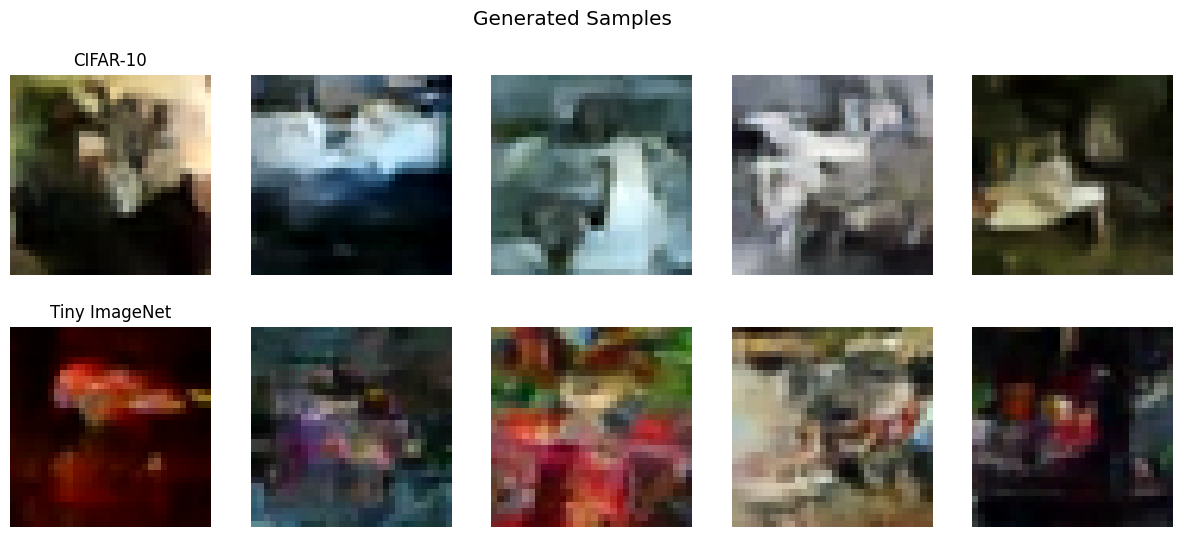

In [ ]:
display_generated_samples(cifar_generated_imgs, imagenet_generated_imgs, 5, IMG_SIZE)
# display_generated_samples(None, imagenet_generated_imgs, 5, IMG_SIZE)
# display_generated_samples(cifar_generated_imgs, None, 5, IMG_SIZE)

## Latent Space DiffiT Model

## References

[1] Hatamizadeh, A., Song, J., Liu, G., Kautz, J., & Vahdat, A. (2023). DiffiT: Diffusion Vision Transformers for Image Generation. ArXiv. /abs/2312.02139

[2] Ho, J., Jain, A., & Abbeel, P. (2020). Denoising Diffusion Probabilistic Models. ArXiv. /abs/2006.11239

[3] [The Annotated Diffusion Model
](https://huggingface.co/blog/annotated-diffusion)

[4] [Coding a Transformer from scratch on PyTorch, with full explanation, training and inference.](https://youtu.be/ISNdQcPhsts?si=dgsOx0BJZRL6jd81)